### Visualize preprocessed dFC data across multiple task paradigms, dFC assessment methods, and TRs (timepoints) for 1 subject

dFC data was first preprocessed and assessed from fMRI BOLD signals using the pydfc package developed by: Mohammad Torabi, Georgios D Mitsis, Jean-Baptiste Poline, On the variability of dynamic functional connectivity assessment methods, GigaScience, Volume 13, 2024, giae009, https://doi.org/10.1093/gigascience/giae009

We visualize dFC now

In [153]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys, os
sys.path.append(os.path.expanduser('~/projects/dFC_task_presence'))
from utilities.utils import harmonize_TR, vec_to_symmetric_matrix, get_n_ROI

###################### SET DESIRED PARAMETERS HERE ##############################
SUBJECT = "sub-f1027ao"
PARADIGM = "axcpt"
dataset_names = [f"{PARADIGM}_tf", f"{PARADIGM}_sw", f"{PARADIGM}_cap"]
#################################################################################

In [154]:
# Load config file
config_path = os.path.expanduser('~/projects/dFC_task_presence/config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

datasets_list = []
for dataset_name in dataset_names:
    my_filepath = config['datasets'][dataset_name]['path']
    dFC_dict = np.load(my_filepath, allow_pickle=True).item()
    datasets_list.append(dFC_dict)
    print(f"{dataset_name} - X loaded with shape: {dFC_dict["X"].shape}")

print(datasets_list[0].keys())
print("Number of unique subjects in first dataset:", len(np.unique(datasets_list[0]['subj_label'])))
ROI = get_n_ROI(1, -1, -2 * datasets_list[0]['X'].shape[1])  # solves quadratic equation for number of ROIs
print("Number of ROIs:", ROI)

axcpt_tf - X loaded with shape: (9356, 4950)
axcpt_sw - X loaded with shape: (8468, 4950)
axcpt_cap - X loaded with shape: (9937, 4950)
dict_keys(['X', 'y', 'subj_label', 'TR_labels', 'measure_name'])
Number of unique subjects in first dataset: 27
Number of ROIs: 100


In [155]:
harmonized_dFC_list = harmonize_TR(datasets_list)   # Harmonize timepoints across assessment methods and subjects
print("Number of samples/dFC matrices for all subjects:", len(harmonized_dFC_list[0]['X']))

subj_datasets_list = []
for dataset in harmonized_dFC_list:
    ds = dataset.copy()
    subj_indices = np.where(dataset['subj_label'] == SUBJECT)[0]  # get indices array out
    
    ds['X'] = ds['X'][subj_indices]
    ds['y'] = ds['y'][subj_indices]
    ds['subj_label'] = ds['subj_label'][subj_indices]
    ds['TR_labels'] = ds['TR_labels'][subj_indices]
    subj_datasets_list.append(ds)

TR_length = len(subj_datasets_list[0]['TR_labels'])  # harmonized so same for each method
print("Number of TRs for that subject:", TR_length)
print("TRs:", subj_datasets_list[0]['TR_labels'])

Number of samples/dFC matrices for all subjects: 6935
Number of TRs for that subject: 431
TRs: [ 18  19  20  21  22  23  24  25  26  27  28  30  31  32  33  34  38  39
  40  41  42  45  46  47  48  49  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  77  78  79  80  81
  86  87  88  89  90  91  92  93  94  95 100 101 102 103 108 109 110 111
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 133
 134 135 136 137 138 139 140 141 142 143 146 147 148 149 150 151 152 153
 154 155 156 161 162 163 164 169 170 171 172 175 176 177 178 179 184 185
 186 187 192 193 194 195 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 223 224 225 226 227 231
 232 233 234 235 236 237 238 239 240 241 244 245 246 247 248 249 250 251
 252 253 254 257 258 259 260 261 266 267 268 269 270 271 272 273 274 275
 278 279 280 281 282 287 288 289 290 293 294 295 296 297 302 303 304 305
 306 307 308 309 310 311 312 

In [158]:
def plot_dFC(subj_dFC_list, n_TR=8, TR_skip=20, TR_start=100):
    """
    Subplot dFC matrices as heatmaps across 2 axes, dFC assessment methods and TR time series.
    
    Parameters:
    subj_dFC_list: list of dFC dictionaries, one for each assessment method
    n_TR: how many TRs to visualize (width of figure)
    TR_skip: interval size of time elapsed between each dFC matrix shown
    TR_start: which TR to start at (approximately since not always available in dataset)
    """
    n_methods = len(dataset_names)

    # Map/find the TRs in labels desired to display
    desired_TRs = np.arange(TR_start, TR_start + n_TR * TR_skip, TR_skip)

    TR_labels = subj_dFC_list[0]['TR_labels']
    TR_indices = [np.argmin(np.abs(TR_labels - tr)) for tr in desired_TRs]    # find indices of the closest available TRs

    # Compute global vmin/vmax so all assessment method rows share one color scale
    all_data = np.concatenate([np.concatenate(ds['X'][TR_indices]) for ds in subj_dFC_list])
    vmin = 0
    vmax = np.max(all_data)

    # Create figure and axes with reduced vertical spacing
    fig, axes = plt.subplots(
        n_methods, n_TR, figsize=(12, 4.5),
        sharey=True, sharex=True,
        gridspec_kw={'hspace': 0.10, 'wspace': 0.05}
    )

    for i in range(len(dataset_names)):
        for j in range(n_TR):
            data = subj_dFC_list[i]['X'][TR_indices[j]]
            matrix = vec_to_symmetric_matrix(data, roi = ROI)
            sns.heatmap(
                matrix, 
                ax=axes[i, j], 
                cmap="magma", 
                cbar=False,
                vmin=vmin,
                vmax=vmax,
                square=True
            )
            TR_labels = subj_dFC_list[i]['TR_labels']
            if i == 0:
                axes[i, j].set_title(f"TR {TR_labels[TR_indices[j]]:.0f}", fontsize=10)
            if j == 0:
                method = dataset_names[i].split('_')[-1]
                if method == "tf":
                    method = "Time-Frequency"
                elif method == "sw":
                    method = "Sliding Window"
                elif method =="cap":
                    method = "CAP"
                axes[i, j].set_ylabel(f"{method}", fontsize=10)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    print("Desired TRs:", desired_TRs)
    print("Mapped TR labels:", TR_labels[TR_indices])
    
    # Create a single long colorbar spanning all rows
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap="magma", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    fig.supylabel(PARADIGM.capitalize(), fontsize=16, x=0.08)
    # plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()

Desired TRs: [200 210 220 230 240 250 260 270]
Mapped TR labels: [200 210 220 231 240 250 260 270]


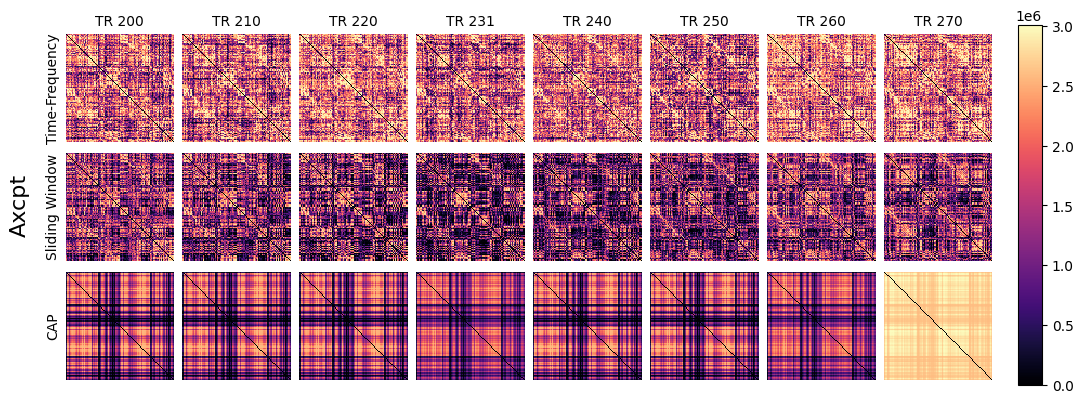

In [159]:
plot_dFC(subj_datasets_list, n_TR=8, TR_start=200, TR_skip=10)